# <img src="https://img.icons8.com/bubbles/50/000000/mind-map.png" style="height:50px;display:inline"> ECE 046211 - Technion - Deep Learning
---

## Project
---

Install packages that are not part of the basic virtual environment defined on the ReadMe.

In [11]:
%pip install datasets
%pip install transformers
%pip install accelerate
%pip install evaluate
%pip install gc

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement gc (from versions: none)
ERROR: No matching distribution found for gc


Import relevant packages

In [53]:
from datasets import load_dataset, Audio,DatasetDict
import numpy as np
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer,AutoConfig
import evaluate
import torch
import gc
from sklearn import metrics
import matplotlib.pyplot as plt

Get gtzan audio files and their corresponding labels from the Hugging Face Hub and split the dataset into training, validation and test sets.

In [13]:
gtzan = load_dataset("marsyas/gtzan", "all",trust_remote_code=True)
train_rest = gtzan["train"].train_test_split(seed=42, shuffle=True, test_size=0.2)
val_test = train_rest["test"].train_test_split(seed=42, shuffle=True, test_size=0.5)
gtzan=DatasetDict({'train': train_rest["train"],'val': val_test["train"],'test': val_test["test"]})

Get AST feature extractor which: 
1. Extracts mel-filter bank features from raw speech.
2. Pads/truncates the features to a fixed length.
3. Normalizes the features(Substracting mean and dividing by the standard deviation).

In [15]:
model_id = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)

Resample the dataset according to the pretrained AST sample rate.

In [ ]:
sampling_rate = feature_extractor.sampling_rate
gtzan = gtzan.cast_column("audio", Audio(sampling_rate=sampling_rate))

Apply AST feature extractor to the dataset. 

In [16]:
max_duration = 30.0


def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
    )
    return inputs

gtzan_encoded = gtzan.map(
    preprocess_function,
    remove_columns=["audio", "file"],
    batched=True,
    batch_size=100,
    num_proc=1,
)

Obtain the label mappings from the dataset.

In [18]:
id2label_fn = gtzan["train"].features["genre"].int2str
gtzan_encoded = gtzan_encoded.rename_column("genre", "label")
id2label = {
    i: id2label_fn(i)
    for i in range(len(gtzan_encoded["train"].features["label"].names))
}
label2id = {v: k for k, v in id2label.items()}

Create accuracy calculation function. 

In [19]:
metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

Get, adjust and train the AST pretrained model.

In [32]:
gc.collect()
torch.cuda.empty_cache()

num_labels = len(id2label)
#Get pretrained model
model = AutoModelForAudioClassification.from_pretrained(model_id)
model.generation_config=AutoConfig.from_pretrained(model_id)
model.generation_config.id2label=id2label
model.generation_config.label2id=label2id
#Adjust model
model.requires_grad_(False)
model.num_labels=num_labels
model.classifier.dense= torch.nn.Linear(model.classifier.dense.in_features,num_labels)
#Define hyperparameters
model_name = model_id.split("/")[-1]
batch_size = 64
gradient_accumulation_steps = 1
num_train_epochs = 50
training_args = TrainingArguments(
    f"{model_name}-finetuned-gtzan",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    push_to_hub=False,
    save_total_limit=5,
    report_to='tensorboard',
)
#Train model
trainer = Trainer(
    model,
    training_args,
    train_dataset=gtzan_encoded["train"].with_format("torch"),
    eval_dataset=gtzan_encoded["val"].with_format("torch"),
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)
train_results =trainer.train()
trainer.save_model('Best_Model')

  8%|▊         | 50/650 [05:43<1:08:46,  6.88s/it]
c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
  1%|          | 5/650 [00:11<25:34,  2.38s/it] 

{'loss': 2.3329, 'grad_norm': 5.239063262939453, 'learning_rate': 3.846153846153847e-06, 'epoch': 0.38}


  2%|▏         | 10/650 [00:27<31:39,  2.97s/it]

{'loss': 2.2946, 'grad_norm': 5.794907093048096, 'learning_rate': 7.692307692307694e-06, 'epoch': 0.77}


  2%|▏         | 13/650 [00:33<22:41,  2.14s/it]


                                                

  2%|▏         | 13/650 [00:38<22:41,  2.14s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 2.365488290786743, 'eval_accuracy': 0.08, 'eval_runtime': 4.7846, 'eval_samples_per_second': 20.901, 'eval_steps_per_second': 0.418, 'epoch': 1.0}


  2%|▏         | 15/650 [00:47<43:55,  4.15s/it]

{'loss': 2.3011, 'grad_norm': 5.509136199951172, 'learning_rate': 1.153846153846154e-05, 'epoch': 1.15}


  3%|▎         | 20/650 [01:03<33:59,  3.24s/it]

{'loss': 2.2809, 'grad_norm': 4.919686317443848, 'learning_rate': 1.5384615384615387e-05, 'epoch': 1.54}


  4%|▍         | 25/650 [01:17<28:40,  2.75s/it]

{'loss': 2.2778, 'grad_norm': 5.832831382751465, 'learning_rate': 1.923076923076923e-05, 'epoch': 1.92}


  4%|▍         | 26/650 [01:18<22:23,  2.15s/it]


                                                

  4%|▍         | 26/650 [01:23<22:23,  2.15s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 2.3237500190734863, 'eval_accuracy': 0.1, 'eval_runtime': 4.8076, 'eval_samples_per_second': 20.8, 'eval_steps_per_second': 0.416, 'epoch': 2.0}


  5%|▍         | 30/650 [01:38<37:27,  3.63s/it]

{'loss': 2.2575, 'grad_norm': 5.117703437805176, 'learning_rate': 2.307692307692308e-05, 'epoch': 2.31}


  5%|▌         | 35/650 [01:48<24:16,  2.37s/it]

{'loss': 2.2369, 'grad_norm': 5.480349063873291, 'learning_rate': 2.6923076923076923e-05, 'epoch': 2.69}


  6%|▌         | 39/650 [01:58<21:23,  2.10s/it]


                                                

  6%|▌         | 39/650 [02:03<21:23,  2.10s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 2.256279230117798, 'eval_accuracy': 0.17, 'eval_runtime': 4.7941, 'eval_samples_per_second': 20.859, 'eval_steps_per_second': 0.417, 'epoch': 3.0}


  6%|▌         | 40/650 [02:09<47:45,  4.70s/it]

{'loss': 2.1614, 'grad_norm': 5.3414225578308105, 'learning_rate': 3.0769230769230774e-05, 'epoch': 3.08}


  7%|▋         | 45/650 [02:24<32:51,  3.26s/it]

{'loss': 2.1609, 'grad_norm': 4.835822105407715, 'learning_rate': 3.461538461538462e-05, 'epoch': 3.46}


  8%|▊         | 50/650 [02:39<30:03,  3.01s/it]

{'loss': 2.1461, 'grad_norm': 4.911396503448486, 'learning_rate': 3.846153846153846e-05, 'epoch': 3.85}


  8%|▊         | 52/650 [02:42<21:55,  2.20s/it]


                                                

  8%|▊         | 52/650 [02:47<21:55,  2.20s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 2.168886661529541, 'eval_accuracy': 0.2, 'eval_runtime': 4.7291, 'eval_samples_per_second': 21.146, 'eval_steps_per_second': 0.423, 'epoch': 4.0}


  8%|▊         | 55/650 [02:54<29:31,  2.98s/it]

{'loss': 2.0935, 'grad_norm': 5.060487747192383, 'learning_rate': 4.230769230769231e-05, 'epoch': 4.23}


  9%|▉         | 60/650 [03:05<22:15,  2.26s/it]

{'loss': 2.0696, 'grad_norm': 4.695326805114746, 'learning_rate': 4.615384615384616e-05, 'epoch': 4.62}


 10%|█         | 65/650 [03:14<16:38,  1.71s/it]

{'loss': 2.006, 'grad_norm': 7.414714336395264, 'learning_rate': 5e-05, 'epoch': 5.0}






                                       
                                                
 10%|█         | 65/650 [03:17<16:38,  1.71s/it]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 2.055361270904541, 'eval_accuracy': 0.33, 'eval_runtime': 3.4117, 'eval_samples_per_second': 29.311, 'eval_steps_per_second': 0.586, 'epoch': 5.0}


 11%|█         | 70/650 [03:29<23:17,  2.41s/it]

{'loss': 1.9454, 'grad_norm': 5.016944408416748, 'learning_rate': 4.9572649572649575e-05, 'epoch': 5.38}


 12%|█▏        | 75/650 [03:40<21:10,  2.21s/it]

{'loss': 1.9221, 'grad_norm': 4.402759552001953, 'learning_rate': 4.9145299145299147e-05, 'epoch': 5.77}


 12%|█▏        | 78/650 [03:45<16:28,  1.73s/it]


                                                

 12%|█▏        | 78/650 [03:49<16:28,  1.73s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.944765567779541, 'eval_accuracy': 0.45, 'eval_runtime': 3.5099, 'eval_samples_per_second': 28.491, 'eval_steps_per_second': 0.57, 'epoch': 6.0}


 12%|█▏        | 80/650 [03:57<34:27,  3.63s/it]

{'loss': 1.8597, 'grad_norm': 4.7926764488220215, 'learning_rate': 4.871794871794872e-05, 'epoch': 6.15}


 13%|█▎        | 85/650 [04:12<29:28,  3.13s/it]

{'loss': 1.8558, 'grad_norm': 4.5063910484313965, 'learning_rate': 4.829059829059829e-05, 'epoch': 6.54}


 14%|█▍        | 90/650 [04:26<26:17,  2.82s/it]

{'loss': 1.7666, 'grad_norm': 4.662779808044434, 'learning_rate': 4.786324786324787e-05, 'epoch': 6.92}


 14%|█▍        | 91/650 [04:27<20:35,  2.21s/it]


                                                

 14%|█▍        | 91/650 [04:32<20:35,  2.21s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.8393017053604126, 'eval_accuracy': 0.54, 'eval_runtime': 4.9775, 'eval_samples_per_second': 20.091, 'eval_steps_per_second': 0.402, 'epoch': 7.0}


 15%|█▍        | 95/650 [04:47<33:24,  3.61s/it]

{'loss': 1.7354, 'grad_norm': 4.640199661254883, 'learning_rate': 4.7435897435897435e-05, 'epoch': 7.31}


 15%|█▌        | 100/650 [05:03<28:57,  3.16s/it]

{'loss': 1.7281, 'grad_norm': 4.438090801239014, 'learning_rate': 4.700854700854701e-05, 'epoch': 7.69}


 16%|█▌        | 104/650 [05:12<20:25,  2.25s/it]


                                                 

 16%|█▌        | 104/650 [05:17<20:25,  2.25s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.7424461841583252, 'eval_accuracy': 0.59, 'eval_runtime': 4.9054, 'eval_samples_per_second': 20.386, 'eval_steps_per_second': 0.408, 'epoch': 8.0}


 16%|█▌        | 105/650 [05:23<42:55,  4.73s/it]

{'loss': 1.6545, 'grad_norm': 4.491676330566406, 'learning_rate': 4.6581196581196586e-05, 'epoch': 8.08}


 17%|█▋        | 110/650 [05:33<23:02,  2.56s/it]

{'loss': 1.6636, 'grad_norm': 4.068767070770264, 'learning_rate': 4.615384615384616e-05, 'epoch': 8.46}


 18%|█▊        | 115/650 [05:44<19:50,  2.23s/it]

{'loss': 1.5576, 'grad_norm': 4.377866268157959, 'learning_rate': 4.572649572649573e-05, 'epoch': 8.85}


 18%|█▊        | 117/650 [05:47<15:20,  1.73s/it]


                                                 

 18%|█▊        | 117/650 [05:50<15:20,  1.73s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.6508008241653442, 'eval_accuracy': 0.62, 'eval_runtime': 3.4219, 'eval_samples_per_second': 29.224, 'eval_steps_per_second': 0.584, 'epoch': 9.0}


 18%|█▊        | 120/650 [05:58<23:53,  2.71s/it]

{'loss': 1.565, 'grad_norm': 3.7286875247955322, 'learning_rate': 4.52991452991453e-05, 'epoch': 9.23}


 19%|█▉        | 125/650 [06:10<22:23,  2.56s/it]

{'loss': 1.513, 'grad_norm': 4.213117599487305, 'learning_rate': 4.4871794871794874e-05, 'epoch': 9.62}


 20%|██        | 130/650 [06:22<18:00,  2.08s/it]

{'loss': 1.5226, 'grad_norm': 4.489349365234375, 'learning_rate': 4.4444444444444447e-05, 'epoch': 10.0}





                                                 

 20%|██        | 130/650 [06:26<18:00,  2.08s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.5726171731948853, 'eval_accuracy': 0.64, 'eval_runtime': 4.5592, 'eval_samples_per_second': 21.934, 'eval_steps_per_second': 0.439, 'epoch': 10.0}


 21%|██        | 135/650 [06:43<27:41,  3.23s/it]

{'loss': 1.479, 'grad_norm': 4.326669216156006, 'learning_rate': 4.401709401709402e-05, 'epoch': 10.38}


 22%|██▏       | 140/650 [06:57<24:49,  2.92s/it]

{'loss': 1.4069, 'grad_norm': 4.721133708953857, 'learning_rate': 4.358974358974359e-05, 'epoch': 10.77}


 22%|██▏       | 143/650 [07:03<17:43,  2.10s/it]



                                       
                                                 
 22%|██▏       | 143/650 [07:07<17:43,  2.10s/it]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.5024341344833374, 'eval_accuracy': 0.65, 'eval_runtime': 4.7145, 'eval_samples_per_second': 21.211, 'eval_steps_per_second': 0.424, 'epoch': 11.0}


 22%|██▏       | 145/650 [07:16<33:33,  3.99s/it]

{'loss': 1.3675, 'grad_norm': 3.7642433643341064, 'learning_rate': 4.316239316239317e-05, 'epoch': 11.15}


 23%|██▎       | 150/650 [07:30<25:25,  3.05s/it]

{'loss': 1.4704, 'grad_norm': 3.615709066390991, 'learning_rate': 4.2735042735042735e-05, 'epoch': 11.54}


 24%|██▍       | 155/650 [07:44<22:28,  2.72s/it]

{'loss': 1.3123, 'grad_norm': 4.222097396850586, 'learning_rate': 4.230769230769231e-05, 'epoch': 11.92}


 24%|██▍       | 156/650 [07:44<17:36,  2.14s/it]


                                                 

 24%|██▍       | 156/650 [07:49<17:36,  2.14s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.434446096420288, 'eval_accuracy': 0.65, 'eval_runtime': 4.4958, 'eval_samples_per_second': 22.243, 'eval_steps_per_second': 0.445, 'epoch': 12.0}


 25%|██▍       | 160/650 [08:02<27:07,  3.32s/it]

{'loss': 1.2667, 'grad_norm': 3.488372802734375, 'learning_rate': 4.1880341880341886e-05, 'epoch': 12.31}


 25%|██▌       | 165/650 [08:16<23:03,  2.85s/it]

{'loss': 1.3329, 'grad_norm': 3.2232022285461426, 'learning_rate': 4.145299145299146e-05, 'epoch': 12.69}


 26%|██▌       | 169/650 [08:24<16:20,  2.04s/it]


                                                 

 26%|██▌       | 169/650 [08:29<16:20,  2.04s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.3729782104492188, 'eval_accuracy': 0.66, 'eval_runtime': 4.6079, 'eval_samples_per_second': 21.702, 'eval_steps_per_second': 0.434, 'epoch': 13.0}


 26%|██▌       | 170/650 [08:34<34:43,  4.34s/it]

{'loss': 1.2597, 'grad_norm': 3.778092861175537, 'learning_rate': 4.1025641025641023e-05, 'epoch': 13.08}


 27%|██▋       | 175/650 [08:48<24:23,  3.08s/it]

{'loss': 1.247, 'grad_norm': 3.8858602046966553, 'learning_rate': 4.05982905982906e-05, 'epoch': 13.46}


 28%|██▊       | 180/650 [09:01<19:23,  2.48s/it]

{'loss': 1.2376, 'grad_norm': 3.626629114151001, 'learning_rate': 4.0170940170940174e-05, 'epoch': 13.85}


 28%|██▊       | 182/650 [09:03<14:25,  1.85s/it]


                                                 

 28%|██▊       | 182/650 [09:07<14:25,  1.85s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.314697265625, 'eval_accuracy': 0.69, 'eval_runtime': 3.4134, 'eval_samples_per_second': 29.296, 'eval_steps_per_second': 0.586, 'epoch': 14.0}


 28%|██▊       | 185/650 [09:15<21:44,  2.81s/it]

{'loss': 1.2326, 'grad_norm': 4.210672378540039, 'learning_rate': 3.974358974358974e-05, 'epoch': 14.23}


 29%|██▉       | 190/650 [09:26<18:26,  2.41s/it]

{'loss': 1.162, 'grad_norm': 3.9075677394866943, 'learning_rate': 3.931623931623932e-05, 'epoch': 14.62}


 30%|███       | 195/650 [09:36<13:46,  1.82s/it]

{'loss': 1.1732, 'grad_norm': 4.096741199493408, 'learning_rate': 3.888888888888889e-05, 'epoch': 15.0}





                                                 

 30%|███       | 195/650 [09:40<13:46,  1.82s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.2637035846710205, 'eval_accuracy': 0.71, 'eval_runtime': 3.6321, 'eval_samples_per_second': 27.532, 'eval_steps_per_second': 0.551, 'epoch': 15.0}


 31%|███       | 200/650 [09:53<19:28,  2.60s/it]

{'loss': 1.1583, 'grad_norm': 2.968465566635132, 'learning_rate': 3.846153846153846e-05, 'epoch': 15.38}


 32%|███▏      | 205/650 [10:04<17:22,  2.34s/it]

{'loss': 1.128, 'grad_norm': 4.806011199951172, 'learning_rate': 3.8034188034188035e-05, 'epoch': 15.77}


 32%|███▏      | 208/650 [10:09<13:26,  1.82s/it]


                                                 

 32%|███▏      | 208/650 [10:13<13:26,  1.82s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.2190039157867432, 'eval_accuracy': 0.72, 'eval_runtime': 3.5958, 'eval_samples_per_second': 27.81, 'eval_steps_per_second': 0.556, 'epoch': 16.0}


 32%|███▏      | 210/650 [10:19<22:17,  3.04s/it]

{'loss': 1.1312, 'grad_norm': 3.302016496658325, 'learning_rate': 3.760683760683761e-05, 'epoch': 16.15}


 33%|███▎      | 215/650 [10:30<17:48,  2.46s/it]

{'loss': 1.1093, 'grad_norm': 3.1077938079833984, 'learning_rate': 3.717948717948718e-05, 'epoch': 16.54}


 34%|███▍      | 220/650 [10:42<16:16,  2.27s/it]

{'loss': 1.0561, 'grad_norm': 3.5847158432006836, 'learning_rate': 3.675213675213676e-05, 'epoch': 16.92}


 34%|███▍      | 221/650 [10:43<13:16,  1.86s/it]


                                                 

 34%|███▍      | 221/650 [10:47<13:16,  1.86s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.1766674518585205, 'eval_accuracy': 0.74, 'eval_runtime': 3.9915, 'eval_samples_per_second': 25.053, 'eval_steps_per_second': 0.501, 'epoch': 17.0}


 35%|███▍      | 225/650 [10:57<19:37,  2.77s/it]

{'loss': 1.1176, 'grad_norm': 3.181340456008911, 'learning_rate': 3.6324786324786323e-05, 'epoch': 17.31}


 35%|███▌      | 230/650 [11:09<16:27,  2.35s/it]

{'loss': 1.0168, 'grad_norm': 3.009915828704834, 'learning_rate': 3.58974358974359e-05, 'epoch': 17.69}


 36%|███▌      | 234/650 [11:16<12:30,  1.81s/it]


                                                 

 36%|███▌      | 234/650 [11:20<12:30,  1.81s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.1368969678878784, 'eval_accuracy': 0.75, 'eval_runtime': 3.5932, 'eval_samples_per_second': 27.83, 'eval_steps_per_second': 0.557, 'epoch': 18.0}


 36%|███▌      | 235/650 [11:24<24:03,  3.48s/it]

{'loss': 1.031, 'grad_norm': 3.0181169509887695, 'learning_rate': 3.5470085470085474e-05, 'epoch': 18.08}


 37%|███▋      | 240/650 [11:35<16:59,  2.49s/it]

{'loss': 1.0491, 'grad_norm': 2.855731964111328, 'learning_rate': 3.504273504273504e-05, 'epoch': 18.46}


 38%|███▊      | 245/650 [11:47<15:40,  2.32s/it]

{'loss': 1.0118, 'grad_norm': 4.107474327087402, 'learning_rate': 3.461538461538462e-05, 'epoch': 18.85}


 38%|███▊      | 247/650 [11:49<12:14,  1.82s/it]


                                                 

 38%|███▊      | 247/650 [11:53<12:14,  1.82s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.1016710996627808, 'eval_accuracy': 0.76, 'eval_runtime': 3.6501, 'eval_samples_per_second': 27.396, 'eval_steps_per_second': 0.548, 'epoch': 19.0}


 38%|███▊      | 250/650 [12:01<18:47,  2.82s/it]

{'loss': 1.0156, 'grad_norm': 3.2064437866210938, 'learning_rate': 3.418803418803419e-05, 'epoch': 19.23}


 39%|███▉      | 255/650 [12:13<15:51,  2.41s/it]

{'loss': 0.9208, 'grad_norm': 2.8422229290008545, 'learning_rate': 3.376068376068376e-05, 'epoch': 19.62}


 40%|████      | 260/650 [12:22<11:52,  1.83s/it]

{'loss': 1.0239, 'grad_norm': 4.057806491851807, 'learning_rate': 3.3333333333333335e-05, 'epoch': 20.0}





                                                 

 40%|████      | 260/650 [12:26<11:52,  1.83s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.0726062059402466, 'eval_accuracy': 0.78, 'eval_runtime': 3.6443, 'eval_samples_per_second': 27.44, 'eval_steps_per_second': 0.549, 'epoch': 20.0}


 41%|████      | 265/650 [12:39<16:20,  2.55s/it]

{'loss': 0.9566, 'grad_norm': 3.2124269008636475, 'learning_rate': 3.290598290598291e-05, 'epoch': 20.38}


 42%|████▏     | 270/650 [12:50<14:48,  2.34s/it]

{'loss': 0.9512, 'grad_norm': 2.664818525314331, 'learning_rate': 3.247863247863248e-05, 'epoch': 20.77}


 42%|████▏     | 273/650 [12:56<11:56,  1.90s/it]


                                                 

 42%|████▏     | 273/650 [13:00<11:56,  1.90s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.0430675745010376, 'eval_accuracy': 0.78, 'eval_runtime': 4.94, 'eval_samples_per_second': 20.243, 'eval_steps_per_second': 0.405, 'epoch': 21.0}


 42%|████▏     | 275/650 [13:09<25:02,  4.01s/it]

{'loss': 0.9488, 'grad_norm': 3.067991256713867, 'learning_rate': 3.205128205128206e-05, 'epoch': 21.15}


 43%|████▎     | 280/650 [13:25<19:46,  3.21s/it]

{'loss': 0.9628, 'grad_norm': 2.845607042312622, 'learning_rate': 3.162393162393162e-05, 'epoch': 21.54}


 44%|████▍     | 285/650 [13:39<17:15,  2.84s/it]

{'loss': 0.9009, 'grad_norm': 3.2043585777282715, 'learning_rate': 3.1196581196581195e-05, 'epoch': 21.92}


 44%|████▍     | 286/650 [13:40<13:32,  2.23s/it]


                                                 

 44%|████▍     | 286/650 [13:45<13:32,  2.23s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.0178064107894897, 'eval_accuracy': 0.78, 'eval_runtime': 4.8809, 'eval_samples_per_second': 20.488, 'eval_steps_per_second': 0.41, 'epoch': 22.0}


 45%|████▍     | 290/650 [14:00<21:38,  3.61s/it]

{'loss': 0.8562, 'grad_norm': 2.86761736869812, 'learning_rate': 3.0769230769230774e-05, 'epoch': 22.31}


 45%|████▌     | 295/650 [14:15<18:35,  3.14s/it]

{'loss': 0.9013, 'grad_norm': 2.7836315631866455, 'learning_rate': 3.034188034188034e-05, 'epoch': 22.69}


 46%|████▌     | 299/650 [14:24<13:10,  2.25s/it]



                                       
                                                 
 46%|████▌     | 299/650 [14:29<13:10,  2.25s/it]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.9942858815193176, 'eval_accuracy': 0.78, 'eval_runtime': 4.9358, 'eval_samples_per_second': 20.26, 'eval_steps_per_second': 0.405, 'epoch': 23.0}


 46%|████▌     | 300/650 [14:35<27:10,  4.66s/it]

{'loss': 0.9432, 'grad_norm': 2.444871425628662, 'learning_rate': 2.9914529914529915e-05, 'epoch': 23.08}


 47%|████▋     | 305/650 [14:51<19:29,  3.39s/it]

{'loss': 0.8975, 'grad_norm': 2.7671382427215576, 'learning_rate': 2.948717948717949e-05, 'epoch': 23.46}


 48%|████▊     | 310/650 [15:08<18:35,  3.28s/it]

{'loss': 0.8625, 'grad_norm': 3.2195017337799072, 'learning_rate': 2.9059829059829063e-05, 'epoch': 23.85}


 48%|████▊     | 312/650 [15:12<13:29,  2.39s/it]


                                                 

 48%|████▊     | 312/650 [15:17<13:29,  2.39s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.9707177877426147, 'eval_accuracy': 0.79, 'eval_runtime': 4.8889, 'eval_samples_per_second': 20.454, 'eval_steps_per_second': 0.409, 'epoch': 24.0}


 48%|████▊     | 315/650 [15:28<21:56,  3.93s/it]

{'loss': 0.8996, 'grad_norm': 3.0922210216522217, 'learning_rate': 2.863247863247863e-05, 'epoch': 24.23}


 49%|████▉     | 320/650 [15:43<17:22,  3.16s/it]

{'loss': 0.8602, 'grad_norm': 2.674356698989868, 'learning_rate': 2.8205128205128207e-05, 'epoch': 24.62}


 50%|█████     | 325/650 [15:56<12:19,  2.28s/it]

{'loss': 0.8019, 'grad_norm': 4.382665634155273, 'learning_rate': 2.777777777777778e-05, 'epoch': 25.0}





                                                 

 50%|█████     | 325/650 [16:01<12:19,  2.28s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.949938952922821, 'eval_accuracy': 0.8, 'eval_runtime': 4.965, 'eval_samples_per_second': 20.141, 'eval_steps_per_second': 0.403, 'epoch': 25.0}


 51%|█████     | 330/650 [16:29<21:52,  4.10s/it]

{'loss': 0.857, 'grad_norm': 2.9804372787475586, 'learning_rate': 2.7350427350427355e-05, 'epoch': 25.38}


 52%|█████▏    | 335/650 [16:44<16:42,  3.18s/it]

{'loss': 0.8254, 'grad_norm': 2.743088722229004, 'learning_rate': 2.6923076923076923e-05, 'epoch': 25.77}


 52%|█████▏    | 338/650 [16:50<11:45,  2.26s/it]



                                       
                                                 
 52%|█████▏    | 338/650 [16:55<11:45,  2.26s/it]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.9302441477775574, 'eval_accuracy': 0.8, 'eval_runtime': 4.8633, 'eval_samples_per_second': 20.562, 'eval_steps_per_second': 0.411, 'epoch': 26.0}


 52%|█████▏    | 340/650 [17:04<22:11,  4.29s/it]

{'loss': 0.823, 'grad_norm': 2.9064066410064697, 'learning_rate': 2.64957264957265e-05, 'epoch': 26.15}


 53%|█████▎    | 345/650 [17:19<16:29,  3.24s/it]

{'loss': 0.8178, 'grad_norm': 2.2934441566467285, 'learning_rate': 2.606837606837607e-05, 'epoch': 26.54}


 54%|█████▍    | 350/650 [17:35<14:28,  2.89s/it]

{'loss': 0.82, 'grad_norm': 2.578023672103882, 'learning_rate': 2.564102564102564e-05, 'epoch': 26.92}


 54%|█████▍    | 351/650 [17:35<11:16,  2.26s/it]


                                                 

 54%|█████▍    | 351/650 [17:40<11:16,  2.26s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.913867175579071, 'eval_accuracy': 0.8, 'eval_runtime': 4.9081, 'eval_samples_per_second': 20.375, 'eval_steps_per_second': 0.407, 'epoch': 27.0}


 55%|█████▍    | 355/650 [17:55<17:49,  3.62s/it]

{'loss': 0.7926, 'grad_norm': 2.768422842025757, 'learning_rate': 2.5213675213675215e-05, 'epoch': 27.31}


 55%|█████▌    | 360/650 [18:11<15:18,  3.17s/it]

{'loss': 0.8379, 'grad_norm': 2.9951348304748535, 'learning_rate': 2.4786324786324787e-05, 'epoch': 27.69}


 56%|█████▌    | 364/650 [18:21<10:51,  2.28s/it]


                                                 

 56%|█████▌    | 364/650 [18:25<10:51,  2.28s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.8977344036102295, 'eval_accuracy': 0.8, 'eval_runtime': 4.8644, 'eval_samples_per_second': 20.557, 'eval_steps_per_second': 0.411, 'epoch': 28.0}


 56%|█████▌    | 365/650 [18:31<22:57,  4.83s/it]

{'loss': 0.8191, 'grad_norm': 2.83225154876709, 'learning_rate': 2.435897435897436e-05, 'epoch': 28.08}


 57%|█████▋    | 370/650 [18:43<12:28,  2.67s/it]

{'loss': 0.7516, 'grad_norm': 3.1051230430603027, 'learning_rate': 2.3931623931623935e-05, 'epoch': 28.46}


 58%|█████▊    | 375/650 [18:54<10:23,  2.27s/it]

{'loss': 0.7876, 'grad_norm': 2.599483013153076, 'learning_rate': 2.3504273504273504e-05, 'epoch': 28.85}


 58%|█████▊    | 377/650 [18:57<08:04,  1.78s/it]


                                                 

 58%|█████▊    | 377/650 [19:00<08:04,  1.78s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.8852179050445557, 'eval_accuracy': 0.8, 'eval_runtime': 3.583, 'eval_samples_per_second': 27.91, 'eval_steps_per_second': 0.558, 'epoch': 29.0}


 58%|█████▊    | 380/650 [19:09<12:54,  2.87s/it]

{'loss': 0.778, 'grad_norm': 2.5060336589813232, 'learning_rate': 2.307692307692308e-05, 'epoch': 29.23}


 59%|█████▉    | 385/650 [19:23<13:03,  2.96s/it]

{'loss': 0.756, 'grad_norm': 2.3424038887023926, 'learning_rate': 2.264957264957265e-05, 'epoch': 29.62}


 60%|██████    | 390/650 [19:37<10:08,  2.34s/it]

{'loss': 0.8011, 'grad_norm': 3.9453213214874268, 'learning_rate': 2.2222222222222223e-05, 'epoch': 30.0}





                                                 

 60%|██████    | 390/650 [19:42<10:08,  2.34s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.8718604445457458, 'eval_accuracy': 0.8, 'eval_runtime': 5.0772, 'eval_samples_per_second': 19.696, 'eval_steps_per_second': 0.394, 'epoch': 30.0}


 61%|██████    | 395/650 [19:59<13:37,  3.20s/it]

{'loss': 0.7823, 'grad_norm': 2.7437586784362793, 'learning_rate': 2.1794871794871795e-05, 'epoch': 30.38}


 62%|██████▏   | 400/650 [20:10<09:49,  2.36s/it]

{'loss': 0.7496, 'grad_norm': 2.496706962585449, 'learning_rate': 2.1367521367521368e-05, 'epoch': 30.77}


 62%|██████▏   | 403/650 [20:15<07:26,  1.81s/it]


                                                 

 62%|██████▏   | 403/650 [20:19<07:26,  1.81s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.8595727682113647, 'eval_accuracy': 0.82, 'eval_runtime': 3.4863, 'eval_samples_per_second': 28.683, 'eval_steps_per_second': 0.574, 'epoch': 31.0}


 62%|██████▏   | 405/650 [20:25<12:21,  3.03s/it]

{'loss': 0.7379, 'grad_norm': 2.667440176010132, 'learning_rate': 2.0940170940170943e-05, 'epoch': 31.15}


 63%|██████▎   | 410/650 [20:36<09:20,  2.34s/it]

{'loss': 0.7498, 'grad_norm': 2.5564117431640625, 'learning_rate': 2.0512820512820512e-05, 'epoch': 31.54}


 64%|██████▍   | 415/650 [20:47<08:26,  2.15s/it]

{'loss': 0.7594, 'grad_norm': 2.4682579040527344, 'learning_rate': 2.0085470085470087e-05, 'epoch': 31.92}


 64%|██████▍   | 416/650 [20:47<06:50,  1.75s/it]


                                                 

 64%|██████▍   | 416/650 [20:51<06:50,  1.75s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.8473607897758484, 'eval_accuracy': 0.82, 'eval_runtime': 3.5931, 'eval_samples_per_second': 27.831, 'eval_steps_per_second': 0.557, 'epoch': 32.0}


 65%|██████▍   | 420/650 [21:02<10:15,  2.68s/it]

{'loss': 0.7158, 'grad_norm': 2.652428150177002, 'learning_rate': 1.965811965811966e-05, 'epoch': 32.31}


 65%|██████▌   | 425/650 [21:13<08:55,  2.38s/it]

{'loss': 0.7491, 'grad_norm': 2.113591194152832, 'learning_rate': 1.923076923076923e-05, 'epoch': 32.69}


 66%|██████▌   | 429/650 [21:21<06:49,  1.85s/it]


                                                 

 66%|██████▌   | 429/650 [21:25<06:49,  1.85s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.8377954363822937, 'eval_accuracy': 0.82, 'eval_runtime': 3.7139, 'eval_samples_per_second': 26.926, 'eval_steps_per_second': 0.539, 'epoch': 33.0}


 66%|██████▌   | 430/650 [21:29<13:21,  3.64s/it]

{'loss': 0.7993, 'grad_norm': 2.96712589263916, 'learning_rate': 1.8803418803418804e-05, 'epoch': 33.08}


 67%|██████▋   | 435/650 [21:40<08:57,  2.50s/it]

{'loss': 0.7704, 'grad_norm': 2.67378830909729, 'learning_rate': 1.837606837606838e-05, 'epoch': 33.46}


 68%|██████▊   | 440/650 [21:51<08:04,  2.31s/it]

{'loss': 0.6657, 'grad_norm': 2.5783004760742188, 'learning_rate': 1.794871794871795e-05, 'epoch': 33.85}


 68%|██████▊   | 442/650 [21:54<06:22,  1.84s/it]


                                                 

 68%|██████▊   | 442/650 [21:59<06:22,  1.84s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.828948974609375, 'eval_accuracy': 0.82, 'eval_runtime': 4.8725, 'eval_samples_per_second': 20.524, 'eval_steps_per_second': 0.41, 'epoch': 34.0}


 68%|██████▊   | 445/650 [22:10<12:07,  3.55s/it]

{'loss': 0.7201, 'grad_norm': 2.388641595840454, 'learning_rate': 1.752136752136752e-05, 'epoch': 34.23}


 69%|██████▉   | 450/650 [22:25<10:06,  3.03s/it]

{'loss': 0.7641, 'grad_norm': 2.35532546043396, 'learning_rate': 1.7094017094017095e-05, 'epoch': 34.62}


 70%|███████   | 455/650 [22:36<06:49,  2.10s/it]

{'loss': 0.7092, 'grad_norm': 3.557727336883545, 'learning_rate': 1.6666666666666667e-05, 'epoch': 35.0}






                                       
                                                 
 70%|███████   | 455/650 [22:41<06:49,  2.10s/it]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.8202550411224365, 'eval_accuracy': 0.82, 'eval_runtime': 4.5551, 'eval_samples_per_second': 21.953, 'eval_steps_per_second': 0.439, 'epoch': 35.0}


 71%|███████   | 460/650 [22:58<10:28,  3.31s/it]

{'loss': 0.7145, 'grad_norm': 2.54404878616333, 'learning_rate': 1.623931623931624e-05, 'epoch': 35.38}


 72%|███████▏  | 465/650 [23:09<07:20,  2.38s/it]

{'loss': 0.7129, 'grad_norm': 1.9766921997070312, 'learning_rate': 1.581196581196581e-05, 'epoch': 35.77}


 72%|███████▏  | 468/650 [23:14<05:24,  1.78s/it]


                                                 

 72%|███████▏  | 468/650 [23:18<05:24,  1.78s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.8132299780845642, 'eval_accuracy': 0.82, 'eval_runtime': 3.433, 'eval_samples_per_second': 29.129, 'eval_steps_per_second': 0.583, 'epoch': 36.0}


 72%|███████▏  | 470/650 [23:24<09:17,  3.10s/it]

{'loss': 0.7101, 'grad_norm': 1.9989314079284668, 'learning_rate': 1.5384615384615387e-05, 'epoch': 36.15}


 73%|███████▎  | 475/650 [23:35<06:49,  2.34s/it]

{'loss': 0.6702, 'grad_norm': 2.728163719177246, 'learning_rate': 1.4957264957264958e-05, 'epoch': 36.54}


 74%|███████▍  | 480/650 [23:45<06:04,  2.14s/it]

{'loss': 0.7403, 'grad_norm': 2.110752582550049, 'learning_rate': 1.4529914529914531e-05, 'epoch': 36.92}


 74%|███████▍  | 481/650 [23:46<04:54,  1.75s/it]


                                                 

 74%|███████▍  | 481/650 [23:50<04:54,  1.75s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.8070117831230164, 'eval_accuracy': 0.81, 'eval_runtime': 3.6801, 'eval_samples_per_second': 27.173, 'eval_steps_per_second': 0.543, 'epoch': 37.0}


 75%|███████▍  | 485/650 [24:01<07:23,  2.69s/it]

{'loss': 0.7121, 'grad_norm': 2.0085365772247314, 'learning_rate': 1.4102564102564104e-05, 'epoch': 37.31}


 75%|███████▌  | 490/650 [24:14<07:21,  2.76s/it]

{'loss': 0.7343, 'grad_norm': 2.667600393295288, 'learning_rate': 1.3675213675213677e-05, 'epoch': 37.69}


 76%|███████▌  | 494/650 [24:23<05:36,  2.16s/it]


                                                 

 76%|███████▌  | 494/650 [24:28<05:36,  2.16s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.80096435546875, 'eval_accuracy': 0.81, 'eval_runtime': 4.9269, 'eval_samples_per_second': 20.297, 'eval_steps_per_second': 0.406, 'epoch': 38.0}


 76%|███████▌  | 495/650 [24:34<12:06,  4.69s/it]

{'loss': 0.6904, 'grad_norm': 2.4722061157226562, 'learning_rate': 1.324786324786325e-05, 'epoch': 38.08}


 77%|███████▋  | 500/650 [24:50<08:23,  3.36s/it]

{'loss': 0.7008, 'grad_norm': 2.476066827774048, 'learning_rate': 1.282051282051282e-05, 'epoch': 38.46}


 78%|███████▊  | 505/650 [25:07<07:37,  3.16s/it]

{'loss': 0.683, 'grad_norm': 1.8160392045974731, 'learning_rate': 1.2393162393162394e-05, 'epoch': 38.85}


 78%|███████▊  | 507/650 [25:10<05:21,  2.25s/it]


                                                 

 78%|███████▊  | 507/650 [25:14<05:21,  2.25s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7953540682792664, 'eval_accuracy': 0.81, 'eval_runtime': 4.8866, 'eval_samples_per_second': 20.464, 'eval_steps_per_second': 0.409, 'epoch': 39.0}


 78%|███████▊  | 510/650 [25:22<07:09,  3.07s/it]

{'loss': 0.689, 'grad_norm': 2.446648359298706, 'learning_rate': 1.1965811965811967e-05, 'epoch': 39.23}


 79%|███████▉  | 515/650 [25:33<05:15,  2.34s/it]

{'loss': 0.7114, 'grad_norm': 2.655254602432251, 'learning_rate': 1.153846153846154e-05, 'epoch': 39.62}


 80%|████████  | 520/650 [25:42<03:48,  1.76s/it]

{'loss': 0.6839, 'grad_norm': 3.253938674926758, 'learning_rate': 1.1111111111111112e-05, 'epoch': 40.0}





                                                 

 80%|████████  | 520/650 [25:46<03:48,  1.76s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7906860113143921, 'eval_accuracy': 0.82, 'eval_runtime': 3.4611, 'eval_samples_per_second': 28.893, 'eval_steps_per_second': 0.578, 'epoch': 40.0}


 81%|████████  | 525/650 [25:59<05:20,  2.56s/it]

{'loss': 0.6905, 'grad_norm': 1.8621762990951538, 'learning_rate': 1.0683760683760684e-05, 'epoch': 40.38}


 82%|████████▏ | 530/650 [26:10<04:34,  2.29s/it]

{'loss': 0.6829, 'grad_norm': 1.9115978479385376, 'learning_rate': 1.0256410256410256e-05, 'epoch': 40.77}


 82%|████████▏ | 533/650 [26:15<03:28,  1.78s/it]



                                       
                                                 
 82%|████████▏ | 533/650 [26:19<03:28,  1.78s/it]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7865918874740601, 'eval_accuracy': 0.82, 'eval_runtime': 3.5703, 'eval_samples_per_second': 28.009, 'eval_steps_per_second': 0.56, 'epoch': 41.0}


 82%|████████▏ | 535/650 [26:25<05:43,  2.99s/it]

{'loss': 0.6974, 'grad_norm': 2.1666438579559326, 'learning_rate': 9.82905982905983e-06, 'epoch': 41.15}


 83%|████████▎ | 540/650 [26:36<04:22,  2.38s/it]

{'loss': 0.6584, 'grad_norm': 2.636431932449341, 'learning_rate': 9.401709401709402e-06, 'epoch': 41.54}


 84%|████████▍ | 545/650 [26:47<03:50,  2.20s/it]

{'loss': 0.6866, 'grad_norm': 2.00365948677063, 'learning_rate': 8.974358974358976e-06, 'epoch': 41.92}


 84%|████████▍ | 546/650 [26:48<03:07,  1.80s/it]


                                                 

 84%|████████▍ | 546/650 [26:51<03:07,  1.80s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7821764349937439, 'eval_accuracy': 0.82, 'eval_runtime': 3.5729, 'eval_samples_per_second': 27.989, 'eval_steps_per_second': 0.56, 'epoch': 42.0}


 85%|████████▍ | 550/650 [27:02<04:30,  2.70s/it]

{'loss': 0.6882, 'grad_norm': 2.0931663513183594, 'learning_rate': 8.547008547008548e-06, 'epoch': 42.31}


 85%|████████▌ | 555/650 [27:14<03:44,  2.36s/it]

{'loss': 0.6789, 'grad_norm': 2.3071541786193848, 'learning_rate': 8.11965811965812e-06, 'epoch': 42.69}


 86%|████████▌ | 559/650 [27:21<02:44,  1.80s/it]


                                                 

 86%|████████▌ | 559/650 [27:25<02:44,  1.80s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7791601419448853, 'eval_accuracy': 0.82, 'eval_runtime': 3.6455, 'eval_samples_per_second': 27.431, 'eval_steps_per_second': 0.549, 'epoch': 43.0}


 86%|████████▌ | 560/650 [27:29<05:15,  3.50s/it]

{'loss': 0.6816, 'grad_norm': 2.318070888519287, 'learning_rate': 7.692307692307694e-06, 'epoch': 43.08}


 87%|████████▋ | 565/650 [27:40<03:31,  2.48s/it]

{'loss': 0.6983, 'grad_norm': 2.7632906436920166, 'learning_rate': 7.264957264957266e-06, 'epoch': 43.46}


 88%|████████▊ | 570/650 [27:51<03:04,  2.30s/it]

{'loss': 0.6369, 'grad_norm': 2.349945306777954, 'learning_rate': 6.837606837606839e-06, 'epoch': 43.85}


 88%|████████▊ | 572/650 [27:54<02:20,  1.81s/it]



                                       
                                                 
 88%|████████▊ | 572/650 [27:58<02:20,  1.81s/it]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7765844464302063, 'eval_accuracy': 0.82, 'eval_runtime': 3.6967, 'eval_samples_per_second': 27.051, 'eval_steps_per_second': 0.541, 'epoch': 44.0}


 88%|████████▊ | 575/650 [28:08<04:15,  3.41s/it]

{'loss': 0.7278, 'grad_norm': 2.373106002807617, 'learning_rate': 6.41025641025641e-06, 'epoch': 44.23}


 89%|████████▉ | 580/650 [28:24<03:36,  3.09s/it]

{'loss': 0.6655, 'grad_norm': 2.510728120803833, 'learning_rate': 5.982905982905984e-06, 'epoch': 44.62}


 90%|█████████ | 585/650 [28:36<02:25,  2.24s/it]

{'loss': 0.6397, 'grad_norm': 3.1303775310516357, 'learning_rate': 5.555555555555556e-06, 'epoch': 45.0}





                                                 

 90%|█████████ | 585/650 [28:42<02:25,  2.24s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7741674780845642, 'eval_accuracy': 0.82, 'eval_runtime': 4.9871, 'eval_samples_per_second': 20.052, 'eval_steps_per_second': 0.401, 'epoch': 45.0}


 91%|█████████ | 590/650 [28:59<03:22,  3.37s/it]

{'loss': 0.6601, 'grad_norm': 2.0882387161254883, 'learning_rate': 5.128205128205128e-06, 'epoch': 45.38}


 92%|█████████▏| 595/650 [29:15<02:50,  3.10s/it]

{'loss': 0.6765, 'grad_norm': 2.1893460750579834, 'learning_rate': 4.700854700854701e-06, 'epoch': 45.77}


 92%|█████████▏| 598/650 [29:20<01:44,  2.00s/it]


                                                 

 92%|█████████▏| 598/650 [29:23<01:44,  2.00s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7722967267036438, 'eval_accuracy': 0.82, 'eval_runtime': 3.462, 'eval_samples_per_second': 28.885, 'eval_steps_per_second': 0.578, 'epoch': 46.0}


 92%|█████████▏| 600/650 [29:32<03:06,  3.72s/it]

{'loss': 0.6918, 'grad_norm': 2.35522198677063, 'learning_rate': 4.273504273504274e-06, 'epoch': 46.15}


 93%|█████████▎| 605/650 [29:46<02:17,  3.04s/it]

{'loss': 0.6276, 'grad_norm': 2.0992279052734375, 'learning_rate': 3.846153846153847e-06, 'epoch': 46.54}


 94%|█████████▍| 610/650 [29:59<01:39,  2.49s/it]

{'loss': 0.7063, 'grad_norm': 1.7624224424362183, 'learning_rate': 3.4188034188034193e-06, 'epoch': 46.92}


 94%|█████████▍| 611/650 [30:00<01:17,  1.98s/it]



                                       
                                                 
 94%|█████████▍| 611/650 [30:03<01:17,  1.98s/it]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7704919576644897, 'eval_accuracy': 0.82, 'eval_runtime': 3.4485, 'eval_samples_per_second': 28.998, 'eval_steps_per_second': 0.58, 'epoch': 47.0}


 95%|█████████▍| 615/650 [30:13<01:32,  2.64s/it]

{'loss': 0.6756, 'grad_norm': 1.8693479299545288, 'learning_rate': 2.991452991452992e-06, 'epoch': 47.31}


 95%|█████████▌| 620/650 [30:25<01:09,  2.30s/it]

{'loss': 0.6937, 'grad_norm': 2.1018528938293457, 'learning_rate': 2.564102564102564e-06, 'epoch': 47.69}


 96%|█████████▌| 624/650 [30:32<00:46,  1.77s/it]


                                                 

 96%|█████████▌| 624/650 [30:35<00:46,  1.77s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7694879174232483, 'eval_accuracy': 0.82, 'eval_runtime': 3.5426, 'eval_samples_per_second': 28.227, 'eval_steps_per_second': 0.565, 'epoch': 48.0}


 96%|█████████▌| 625/650 [30:38<01:21,  3.26s/it]

{'loss': 0.6239, 'grad_norm': 2.0959033966064453, 'learning_rate': 2.136752136752137e-06, 'epoch': 48.08}


 97%|█████████▋| 630/650 [30:50<00:47,  2.40s/it]

{'loss': 0.6728, 'grad_norm': 2.1352391242980957, 'learning_rate': 1.7094017094017097e-06, 'epoch': 48.46}


 98%|█████████▊| 635/650 [31:01<00:34,  2.28s/it]

{'loss': 0.6833, 'grad_norm': 2.2368569374084473, 'learning_rate': 1.282051282051282e-06, 'epoch': 48.85}


 98%|█████████▊| 637/650 [31:04<00:23,  1.79s/it]


                                                 

 98%|█████████▊| 637/650 [31:07<00:23,  1.79s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7687787413597107, 'eval_accuracy': 0.82, 'eval_runtime': 3.5339, 'eval_samples_per_second': 28.297, 'eval_steps_per_second': 0.566, 'epoch': 49.0}


 98%|█████████▊| 640/650 [31:15<00:27,  2.75s/it]

{'loss': 0.6232, 'grad_norm': 2.4602153301239014, 'learning_rate': 8.547008547008548e-07, 'epoch': 49.23}


 99%|█████████▉| 645/650 [31:26<00:11,  2.33s/it]

{'loss': 0.7182, 'grad_norm': 2.387871265411377, 'learning_rate': 4.273504273504274e-07, 'epoch': 49.62}


100%|██████████| 650/650 [31:36<00:00,  1.82s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'loss': 0.6349, 'grad_norm': 4.161049842834473, 'learning_rate': 0.0, 'epoch': 50.0}





                                                 

100%|██████████| 650/650 [31:40<00:00,  1.82s/it]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.768552839756012, 'eval_accuracy': 0.82, 'eval_runtime': 3.5648, 'eval_samples_per_second': 28.052, 'eval_steps_per_second': 0.561, 'epoch': 50.0}



100%|██████████| 650/650 [31:41<00:00,  2.93s/it]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'train_runtime': 1901.4825, 'train_samples_per_second': 21.01, 'train_steps_per_second': 0.342, 'train_loss': 1.0783195990782517, 'epoch': 50.0}


Calculate test metrics

100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

{'test_loss': 0.7949377298355103, 'test_accuracy': 0.85, 'test_runtime': 3.3762, 'test_samples_per_second': 29.619, 'test_steps_per_second': 0.592}


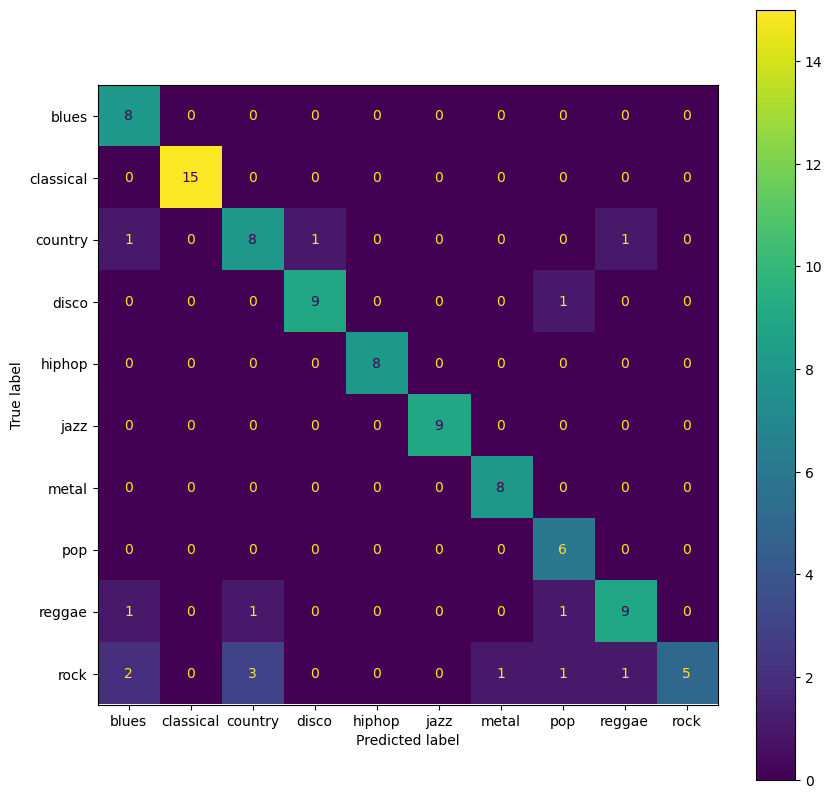

<Figure size 640x480 with 0 Axes>

In [58]:
pred=trainer.predict(gtzan_encoded["test"].with_format("torch"))
print(pred.metrics)
confusion_matrix=metrics.confusion_matrix(pred.label_ids, np.argmax(pred.predictions, axis=1))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(label2id.keys()))
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
fig.savefig('images/Test_confusion_matrix.jpg')
plt.show()